In [1]:
# Install necessary packages
!apt-get -qq install -y cmake libopencv-dev

# Clone OpenCV repository
!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

# Create build directory
!mkdir /content/build
%cd /content/build

# Configure OpenCV with CMake
!cmake -DOPENCV_ENABLE_NONFREE=ON -DOPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules /content/opencv

# Build and install OpenCV
!make -j8
!make install

Cloning into 'opencv'...
remote: Enumerating objects: 343867, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 343867 (delta 50), reused 24 (delta 23), pack-reused 343756 (from 2)
Receiving objects: 100% (343867/343867), 532.50 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (239908/239908), done.
Updating files: 100% (7620/7620), done.
Cloning into 'opencv_contrib'...
remote: Enumerating objects: 43422, done.
remote: Counting objects: 100% (6689/6689), done.
remote: Compressing objects: 100% (1772/1772), done.
remote: Total 43422 (delta 5382), reused 4917 (delta 4917), pack-reused 36733 (from 2)
Receiving objects: 100% (43422/43422), 152.16 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (26877/26877), done.
/content/build
CMake Deprecation Warning at CMakeLists.txt:25 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> valu

In [4]:
import cv2
# lets check the documentation of surf algorithm
help(cv2.xfeatures2d.SURF_create)

Help on built-in function SURF_create:

SURF_create(...)
    SURF_create([, hessianThreshold[, nOctaves[, nOctaveLayers[, extended[, upright]]]]]) -> retval
    .   @param hessianThreshold Threshold for hessian keypoint detector used in SURF.
    .       @param nOctaves Number of pyramid octaves the keypoint detector will use.
    .       @param nOctaveLayers Number of octave layers within each octave.
    .       @param extended Extended descriptor flag (true - use extended 128-element descriptors; false - use
    .       64-element descriptors).
    .       @param upright Up-right or rotated features flag (true - do not compute orientation of features;
    .       false - compute orientation).



In [6]:
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
import os
import random
from scipy.ndimage import gaussian_filter, convolve
from scipy.signal import convolve2d
from scipy.spatial import cKDTree
from skimage.feature import hog
import math
from numpy.fft import fft2, ifft2
import time

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# cd /content/drive/MyDrive/CV_Final

In [9]:
path = "/content/drive/My Drive/CV_Final/dataset/final_proj"

In [47]:
def load_dataset(root_dir):
    root = Path(root_dir)
    dataset = {}

    for folder in sorted(root.iterdir()):
        if not folder.is_dir():
            continue

        images = {}
        transforms = {}

        # 1) load all PPM and PGM images
        for ext in ('ppm', 'pgm'):
            for img_path in sorted(folder.glob(f'img*.{ext}')):
                idx = int(img_path.stem.replace('img', ''))
                img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
                if img is None:
                    raise FileNotFoundError(f"Could not load image {img_path}")
                images[idx] = img

        # 2) load all homography files (H<from>to<to>p)
        pattern = re.compile(r'H(\d+)to(\d+)p')
        for mat_path in sorted(folder.iterdir()):
            m = pattern.match(mat_path.stem)
            if not m:
                continue
            i_from, i_to = map(int, m.groups())
            H = np.loadtxt(mat_path, dtype=np.float32)
            if H.size != 9:
                raise ValueError(f"Expected 9 values in {mat_path}, got {H.size}")
            transforms[(i_from, i_to)] = H.reshape(3, 3)

        dataset[folder.name] = {
            'images': images,
            'transforms': transforms
        }

    return dataset

In [48]:
# --- Usage ---
data = load_dataset(path)

# e.g. grab blur_1 -> image 1 and the H1->2 matrix:
img1 = data['blur_1']['images'][1]
H_1_to_2 = data['blur_1']['transforms'][(1, 2)]

print("H1To2 =\n", H_1_to_2)

H1To2 =
 [[ 1.0107878e+00  8.2814684e-03  1.8576799e+01]
 [-4.9128886e-03  1.0148779e+00 -2.8851517e+01]
 [-1.9166087e-06  8.1537619e-06  1.0000000e+00]]


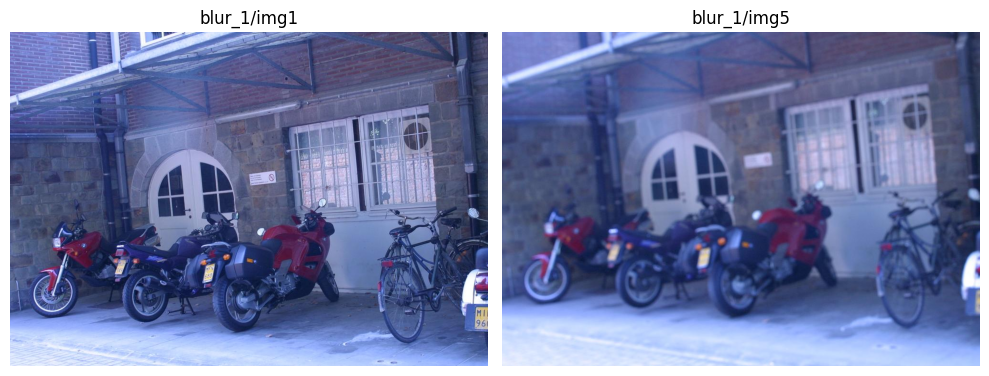

In [49]:
# pick your distortion folder and image indices:
folder = 'blur_1'
i1, i2 = 1, 5

# grab the BGR images
img1_bgr = data[folder]['images'][i1]
img2_bgr = data[folder]['images'][i2]

# convert to RGB for matplotlib
img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

# plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.title(f'{folder}/img{i1}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title(f'{folder}/img{i2}')
plt.axis('off')

plt.tight_layout()
plt.show()

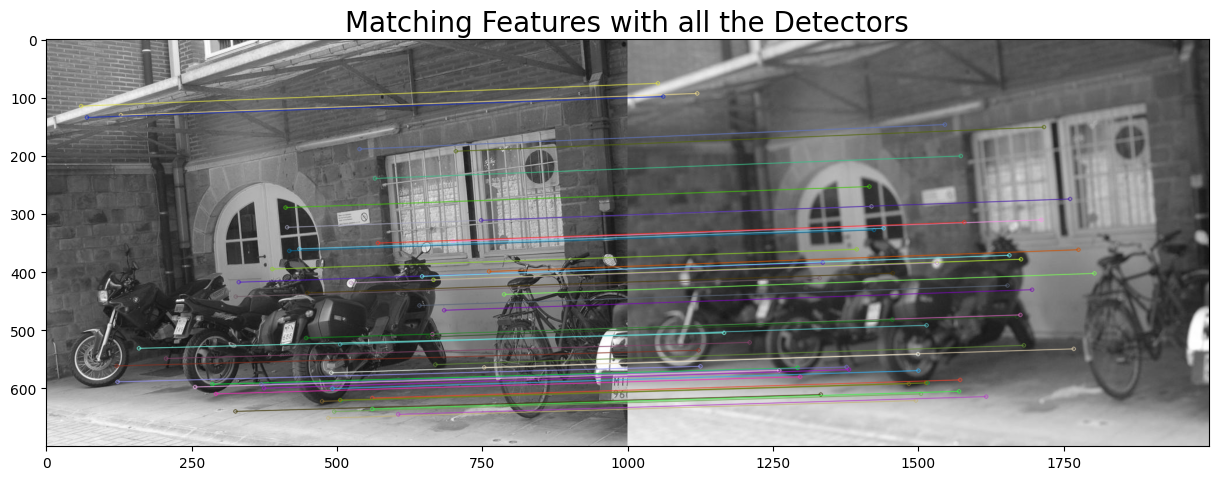

In [50]:
%matplotlib inline

img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

#surf
surf = cv2.xfeatures2d.SURF_create()

keypoints_1, descriptors_1 = surf.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = surf.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

plt.rcParams['figure.figsize'] = (15, 18)
img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3)
plt.title('Matching Features with all the Detectors', fontsize = 20)
plt.show()

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import cKDTree

def evaluate_matching_performance(img1, img2, homography, descriptor_type, distance_thresholds=None, pixel_error_threshold=3.0):
    """
    Evaluate descriptor matching with accurate recall calculation and runtime measurement.
    Generates recall-precision curve data across multiple distance thresholds.

    Parameters:
    - img1, img2: Input images
    - homography: Homography matrix between images
    - descriptor_type: Type of descriptor to use ('sift', 'surf', etc.)
    - distance_thresholds: List of distance thresholds to use for curve generation
                          If None, auto-generates thresholds
    - pixel_error_threshold: Threshold for correspondence validation

    Returns:
    - results: Dictionary with matching statistics
    - img_matches: Visualization of matches
    - runtime: Processing time
    - curve_data: Points for recall-precision curve
    """
    # Start timing
    start_time = time.time()

    # First, find all possible correspondences (ground truth)
    correspondences, keypoints1, keypoints2, descriptors1, descriptors2 = find_correspondences_efficient(
        img1, img2, homography, descriptor_type, pixel_error_threshold
    )

    # Match descriptors
    bf = cv2.BFMatcher()
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance for better visualization and threshold application
    matches = sorted(matches, key=lambda x: x.distance)

    # If no thresholds provided, generate them automatically
    if distance_thresholds is None:
        if len(matches) > 0:
            min_dist = matches[0].distance
            max_dist = matches[-1].distance
            # Generate range of thresholds from min to max distance
            distance_thresholds = np.linspace(min_dist, max_dist, 20)
        else:
            distance_thresholds = [100]  # Default if no matches

    # Generate curve data points
    curve_data = []
    correspondence_pairs = set(correspondences)

    # Calculate recall-precision points for each threshold
    for threshold in distance_thresholds:
        # Apply distance threshold
        thresholded_matches = [m for m in matches if m.distance < threshold]

        # Count correct and false matches
        correct_matches = []
        false_matches = []

        for m in thresholded_matches:
            if (m.queryIdx, m.trainIdx) in correspondence_pairs:
                correct_matches.append(m)
            else:
                false_matches.append(m)

        # Calculate recall and precision
        num_correct = len(correct_matches)
        num_false = len(false_matches)

        recall = num_correct / max(1, len(correspondences))
        one_minus_precision = num_false / max(1, num_correct + num_false)
        precision = 1 - one_minus_precision

        # Add point to curve data
        curve_data.append({
            'threshold': threshold,
            'recall': recall,
            '1-precision': one_minus_precision,
            'precision': precision,
            'correct_matches': num_correct,
            'false_matches': num_false
        })

    # Use the results from the middle threshold for the standard evaluation
    mid_idx = len(distance_thresholds) // 2
    mid_threshold = distance_thresholds[mid_idx]
    mid_data = curve_data[mid_idx]

    # Create visualization with matches from mid threshold
    thresholded_matches = [m for m in matches if m.distance < mid_threshold]
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2,
                                  thresholded_matches[:50], img2, flags=2)

    # Calculate runtime
    runtime = time.time() - start_time

    # Prepare results
    results = {
        "descriptor_type": descriptor_type,
        "total_keypoints_img1": len(keypoints1),
        "total_keypoints_img2": len(keypoints2),
        "total_matches": len(matches),
        "thresholded_matches": len(thresholded_matches),
        "num_correspondences": len(correspondences),
        "num_correct_matches": mid_data['correct_matches'],
        "num_false_matches": mid_data['false_matches'],
        "recall": mid_data['recall'],
        "precision": mid_data['precision'],
        "1-precision": mid_data['1-precision'],
        "threshold_used": mid_threshold
    }

    return results, img_matches, runtime, curve_data

def find_correspondences_efficient(img1, img2, homography, descriptor_type, pixel_error_threshold=3.0):
    """
    Find all potential correspondences efficiently using spatial indexing.
    """
    # Extract features using the specified descriptor
    keypoints1, descriptors1 = extract_features(img1, descriptor_type)
    keypoints2, descriptors2 = extract_features(img2, descriptor_type)

    # Convert keypoints to numpy arrays for faster processing
    kp1_array = np.array([kp.pt for kp in keypoints1])
    kp2_array = np.array([kp.pt for kp in keypoints2])

    # Build KD-Tree for keypoints in img2 for efficient nearest-neighbor search
    tree = cKDTree(kp2_array)
    correspondences = []
    h2, w2 = img2.shape[:2]

    try:
        # Apply homography to all points at once
        kp1_transformed = []
        for pt in kp1_array:
            pt_h = np.array([pt[0], pt[1], 1.0])
            pt_transformed = np.dot(homography, pt_h)
            # Convert from homogeneous coordinates
            pt_transformed = pt_transformed[:2] / pt_transformed[2]
            kp1_transformed.append(pt_transformed)
        kp1_transformed = np.array(kp1_transformed)

        # Find valid points (within image boundaries)
        valid_indices = np.where(
            (kp1_transformed[:, 0] >= 0) &
            (kp1_transformed[:, 0] < w2) &
            (kp1_transformed[:, 1] >= 0) &
            (kp1_transformed[:, 1] < h2)
        )[0]

        # Query the KD-Tree for nearest neighbors
        distances, indices = tree.query(kp1_transformed[valid_indices], k=1)

        # Filter by distance threshold
        valid_correspondences = np.where(distances < pixel_error_threshold)[0]

        # Create correspondence list
        for i, idx in enumerate(valid_correspondences):
            orig_idx = valid_indices[idx]
            nearest_idx = indices[idx]
            correspondences.append((orig_idx, nearest_idx))
    except Exception as e:
        print(f"Error in transformation: {e}")

    return correspondences, keypoints1, keypoints2, descriptors1, descriptors2

def extract_features(img, descriptor_type):
    """
    Extract features using Hessian detector and specified descriptor type.
    Returns keypoints and descriptors.
    """
    # Convert image to grayscale if needed
    if len(img.shape) > 2 and img.shape[2] > 1:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img.copy()

    # Use Hessian detector consistently
    hessian_detector = cv2.xfeatures2d.SURF_create(hessianThreshold=100, extended=False, upright=False)
    keypoints = hessian_detector.detect(gray_img, None)
    descriptors = None

    # Apply different descriptors based on type
    if descriptor_type == "sift":
        sift = cv2.SIFT_create()
        _, descriptors = sift.compute(gray_img, keypoints)
    elif descriptor_type == "surf":
        surf = cv2.xfeatures2d.SURF_create()
        _, descriptors = surf.compute(gray_img, keypoints)
        descriptors = np.float32(descriptors)
    elif descriptor_type == "orb":
        orb = cv2.ORB_create()
        _, descriptors = orb.compute(gray_img, keypoints)
    elif descriptor_type == "brisk":
        brisk = cv2.BRISK_create()
        _, descriptors = brisk.compute(gray_img, keypoints)
    elif descriptor_type == "brief":
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        _, descriptors = brief.compute(gray_img, keypoints)
    elif descriptor_type == "freak":
        freak = cv2.xfeatures2d.FREAK_create()
        _, descriptors = freak.compute(gray_img, keypoints)
    else:
        raise ValueError(f"Unsupported descriptor type: {descriptor_type}")

    return keypoints, descriptors

def plot_recall_precision_curve(curve_data, descriptor_type):
    """
    Plot recall-precision curve from the provided data.

    Parameters:
    - curve_data: List of dictionaries with recall and 1-precision values
    - descriptor_type: Type of descriptor used (for title)
    """
    plt.figure(figsize=(10, 6))

    # Extract x and y values
    x_values = [point['1-precision'] for point in curve_data]
    y_values = [point['recall'] for point in curve_data]

    # Sort points by x-value for proper curve display
    sorted_points = sorted(zip(x_values, y_values))
    x_sorted = [x for x, y in sorted_points]
    y_sorted = [y for x, y in sorted_points]

    # Plot the curve
    plt.plot(x_sorted, y_sorted, 'b-', marker='o', markersize=4, linewidth=2)

    # Add ideal point (0,1) and line from origin
    plt.plot([0, 0], [0, 1], 'r--', linewidth=1)  # Vertical line at x=0
    plt.plot([0], [1], 'ro', markersize=8)  # Ideal point

    # Set labels and title
    plt.xlabel('1 - Precision')
    plt.ylabel('Recall')
    plt.title(f'Recall-Precision Curve for {descriptor_type} Descriptor')

    # Set axis limits
    plt.xlim(-0.05, min(1.05, max(x_sorted) * 1.1))
    plt.ylim(-0.05, 1.05)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_sift_surf_comparison(pair_results, current_descriptor=None):
    """
    Plot SIFT and SURF recall-precision curves on the same graph.

    Parameters:
    - pair_results: Dictionary containing both SIFT and SURF results
    - current_descriptor: The descriptor type currently being processed (for highlighting)
    """
    plt.figure(figsize=(10, 6))

    # Process SIFT data
    sift_data = pair_results['sift']['curve_data']
    sift_x = [point['1-precision'] for point in sift_data]
    sift_y = [point['recall'] for point in sift_data]
    sift_points = sorted(zip(sift_x, sift_y))
    sift_x_sorted = [x for x, y in sift_points]
    sift_y_sorted = [y for x, y in sift_points]

    # Process SURF data
    surf_data = pair_results['surf']['curve_data']
    surf_x = [point['1-precision'] for point in surf_data]
    surf_y = [point['recall'] for point in surf_data]
    surf_points = sorted(zip(surf_x, surf_y))
    surf_x_sorted = [x for x, y in surf_points]
    surf_y_sorted = [y for x, y in surf_points]

    # Define line styles - make the current descriptor line thicker
    sift_style = 'b-'
    surf_style = 'r-'
    sift_width = 2
    surf_width = 2

    if current_descriptor == 'sift':
        sift_width = 3
    elif current_descriptor == 'surf':
        surf_width = 3

    # Plot both curves on the same figure
    plt.plot(sift_x_sorted, sift_y_sorted, sift_style, marker='o', markersize=4,
             linewidth=sift_width, label='SIFT')
    plt.plot(surf_x_sorted, surf_y_sorted, surf_style, marker='o', markersize=4,
             linewidth=surf_width, label='SURF')

    # Add ideal point (0,1)
    plt.plot([0], [1], 'ko', markersize=8, label='Ideal Point')

    # Set labels and title
    plt.xlabel('1 - Precision')
    plt.ylabel('Recall')
    plt.title('SIFT vs SURF Recall-Precision Comparison')

    # Set axis limits - use max of both curves plus padding
    max_x = max(max(sift_x_sorted), max(surf_x_sorted))
    plt.xlim(-0.05, min(1.05, max_x * 1.1))
    plt.ylim(-0.05, 1.05)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

    return

def display_matching_results(img_matches, results, curve_data, descriptor_type=None, pair_results=None):
    """
    Display the matching results visually, print evaluation metrics,
    and plot the recall-precision curve.

    Parameters:
    - img_matches: Image with matches drawn on it
    - results: Dictionary with matching statistics
    - curve_data: List of dictionaries with recall-precision curve data
    - descriptor_type: Descriptor type string
    - pair_results: Optional dictionary containing both SIFT and SURF results for comparison
    """
    if descriptor_type is None and 'descriptor_type' in results:
        descriptor_type = results['descriptor_type']

    # Display matching image
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f'Feature Matching with {descriptor_type.upper()} Descriptor')
    plt.axis('off')
    plt.show()

    # Print results to console
    print(f"\n--- Results for {descriptor_type.upper()} Descriptor ---")
    print(f"Keypoints: {results['total_keypoints_img1']} (img1), {results['total_keypoints_img2']} (img2)")
    print(f"Matches: {results['thresholded_matches']} (after threshold) / {results['total_matches']} (total)")
    print(f"Correct/False: {results['num_correct_matches']} / {results['num_false_matches']}")
    print(f"Recall: {results['recall']:.4f}, 1-Precision: {results['1-precision']:.4f}")
    print(f"Threshold used: {results['threshold_used']:.2f}")

    # If we have both SIFT and SURF results, plot them together
    if pair_results and 'sift' in pair_results and 'surf' in pair_results:
        plot_sift_surf_comparison(pair_results, descriptor_type)
    else:
        # Otherwise, just plot this descriptor's curve
        plot_recall_precision_curve(curve_data, descriptor_type)

    return

def compare_sift_surf_for_pair(pair_results, folder_name, pair_key):
    """
    Compare SIFT and SURF performance for a specific image pair.
    Prints a summary table comparing metrics.

    Parameters:
    - pair_results: Dictionary with results for this image pair
    - folder_name: Name of the folder
    - pair_key: Key identifying the image pair
    """
    # We've already shown the combined graph during the individual evaluations
    # Just print the summary table here
    print(f"\n--- SIFT vs SURF Summary for {folder_name}, {pair_key} ---")
    print(f"{'Descriptor':<10} {'Recall':<10} {'1-Precision':<12} {'Runtime (s)':<12}")
    print("-" * 45)

    for descriptor_type in ['sift', 'surf']:
        if descriptor_type in pair_results:
            results = pair_results[descriptor_type]['results']
            runtime = pair_results[descriptor_type]['runtime']
            print(f"{descriptor_type:<10} {results['recall']:<10.4f} {results['1-precision']:<12.4f} {runtime:<12.3f}")

    print("\n")
    return

def evaluate_all_image_pairs(data, descriptor_types=["sift", "surf"]):
    """
    Evaluate feature matching performance across all image pairs in the dataset.

    Parameters:
    - data: The loaded dataset with images and homography matrices
    - descriptor_types: List of descriptor types to evaluate, defaults to SIFT and SURF only

    Returns:
    - A dictionary with evaluation results for each image pair and descriptor
    """
    all_results = {}

    for folder_name, folder_data in data.items():
        if "2" in folder_name:
            continue

        print(f"\nProcessing folder: {folder_name}")
        all_results[folder_name] = {}

        # Get the images and transforms for this folder
        images = folder_data['images']
        transforms = folder_data['transforms']

        # Process each image pair with a known homography
        for (i, j), homography in transforms.items():
            # Only process if both images exist in the dataset
            if i in images and j in images:
                img1 = images[i]
                img2 = images[j]
                pair_key = f"img{i}_to_img{j}"

                print(f"Processing image pair: {pair_key}")
                all_results[folder_name][pair_key] = {}

                img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
                img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

                # First, process both descriptors
                for descriptor_type in descriptor_types:
                    print(f"Using {descriptor_type} descriptor...")

                    # Run the evaluation
                    results, img_matches, exec_time, curve_data = evaluate_matching_performance(
                        img1, img2, homography,
                        descriptor_type=descriptor_type,
                        distance_thresholds=None,  # Auto-generate thresholds
                        pixel_error_threshold=3.0
                    )

                    # Store results
                    all_results[folder_name][pair_key][descriptor_type] = {
                        'results': results,
                        'img_matches': img_matches,
                        'runtime': exec_time,
                        'curve_data': curve_data
                    }

                # Now display results for each descriptor with combined plots
                for descriptor_type in descriptor_types:
                    results = all_results[folder_name][pair_key][descriptor_type]['results']
                    img_matches = all_results[folder_name][pair_key][descriptor_type]['img_matches']
                    curve_data = all_results[folder_name][pair_key][descriptor_type]['curve_data']
                    exec_time = all_results[folder_name][pair_key][descriptor_type]['runtime']

                    # Display results with SIFT and SURF curves together
                    display_matching_results(
                        img_matches,
                        results,
                        curve_data,
                        descriptor_type,
                        pair_results=all_results[folder_name][pair_key]
                    )
                    print(f"Runtime: {exec_time:.3f} seconds")
                    print()

                # After processing both descriptors, show a comparison summary
                compare_sift_surf_for_pair(all_results[folder_name][pair_key], folder_name, pair_key)
            else:
                print(f"  Skipping pair ({i}, {j}) because one or both images are missing")

    return all_results

def plot_aggregated_results(all_results):
    """
    Create aggregated plots of performance metrics across all image pairs.

    Parameters:
    - all_results: Dictionary with evaluation results
    """
    # Data storage for aggregation
    descriptor_data = {
        'sift': {'recall': [], '1-precision': [], 'runtime': []},
        'surf': {'recall': [], '1-precision': [], 'runtime': []},
        'orb': {'recall': [], '1-precision': [], 'runtime': []},
        'brisk': {'recall': [], '1-precision': [], 'runtime': []},
        'brief': {'recall': [], '1-precision': [], 'runtime': []},
        'freak': {'recall': [], '1-precision': [], 'runtime': []}
    }

    # Collect data from all image pairs
    for folder_name, folder_results in all_results.items():
        for pair_key, pair_results in folder_results.items():
            for descriptor_type, descriptor_results in pair_results.items():
                if descriptor_type in descriptor_data:
                    results = descriptor_results['results']
                    runtime = descriptor_results['runtime']

                    descriptor_data[descriptor_type]['recall'].append(results['recall'])
                    descriptor_data[descriptor_type]['1-precision'].append(results['1-precision'])
                    descriptor_data[descriptor_type]['runtime'].append(runtime)

    # Create comparison plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # List of descriptor types to compare
    descriptors = [d for d in descriptor_data.keys() if len(descriptor_data[d]['recall']) > 0]

    # Plot 1: Average Recall
    avg_recall = [np.mean(descriptor_data[d]['recall']) for d in descriptors]
    axs[0].bar(descriptors, avg_recall, color='skyblue')
    axs[0].set_title('Average Recall')
    axs[0].set_ylim(0, 1)
    axs[0].grid(True, linestyle='--', alpha=0.7, axis='y')

    # Plot 2: Average 1-Precision (lower is better)
    avg_precision = [np.mean(descriptor_data[d]['1-precision']) for d in descriptors]
    axs[1].bar(descriptors, avg_precision, color='salmon')
    axs[1].set_title('Average 1-Precision (lower is better)')
    axs[1].set_ylim(0, 1)
    axs[1].grid(True, linestyle='--', alpha=0.7, axis='y')

    # Plot 3: Average Runtime
    avg_runtime = [np.mean(descriptor_data[d]['runtime']) for d in descriptors]
    axs[2].bar(descriptors, avg_runtime, color='lightgreen')
    axs[2].set_title('Average Runtime (seconds)')
    axs[2].grid(True, linestyle='--', alpha=0.7, axis='y')

    plt.tight_layout()
    plt.show()

    # Create scatter plot of Recall vs 1-Precision (aggregated)
    plt.figure(figsize=(10, 8))

    colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow']

    for i, descriptor in enumerate(descriptors):
        recalls = descriptor_data[descriptor]['recall']
        precisions = descriptor_data[descriptor]['1-precision']

        if recalls and precisions:  # Check if the lists are not empty
            plt.scatter(precisions, recalls,
                      label=descriptor.upper(),
                      color=colors[i % len(colors)],
                      alpha=0.7, s=50)

    # Add ideal point
    plt.plot([0], [1], 'ko', markersize=10, label='Ideal Point')

    # Add lines to show the average for each descriptor
    for i, descriptor in enumerate(descriptors):
        avg_recall = np.mean(descriptor_data[descriptor]['recall'])
        avg_precision = np.mean(descriptor_data[descriptor]['1-precision'])

        plt.plot([avg_precision], [avg_recall], 'o',
                markersize=12, markeredgewidth=2,
                markeredgecolor='black',
                markerfacecolor=colors[i % len(colors)])

    plt.xlabel('1 - Precision')
    plt.ylabel('Recall')
    plt.title('Recall vs 1-Precision for All Image Pairs')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Print summary table for all descriptors
    print("\n--- Summary of All Descriptors ---")
    print(f"{'Descriptor':<10} {'Avg Recall':<12} {'Avg 1-Precision':<16} {'Avg Runtime (s)':<16}")
    print("-" * 60)

    for descriptor in descriptors:
        avg_recall = np.mean(descriptor_data[descriptor]['recall'])
        avg_precision = np.mean(descriptor_data[descriptor]['1-precision'])
        avg_runtime = np.mean(descriptor_data[descriptor]['runtime'])

        print(f"{descriptor:<10} {avg_recall:<12.4f} {avg_precision:<16.4f} {avg_runtime:<16.3f}")

    return

In [58]:

"""
Main function to run the evaluation.
"""
# Load dataset
print("GET HERE")
dataset_path = path
data = load_dataset(dataset_path)

# Evaluate all image pairs with different descriptors
descriptor_types = ["sift", "surf"]
all_results = evaluate_all_image_pairs(data, descriptor_types)

Output hidden; open in https://colab.research.google.com to view.